# Image model initial evaluation
Se evalúa un modelo de imagen entrenado aplicando las optimizaciones mínimas en la conversión a TensorFlow Lite.
## Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
from joblib import load
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from image_model_evaluation import COLOR_MODE, DIGITS, MICRO, EXT, PRUN, QAT

## Parámetros

In [2]:
model = QAT
data_origin = MICRO

project_dir = "/home/daniel/PycharmProjects/tfg-tinyml"

if model == EXT:
    if model == EXT:
        model_name = "ExtImgDataModel"
    else:
        model_name = "ExtImgDataModelPrun"

    if data_origin == EXT:
        test_dir = f"{project_dir}/samples/external/preprocessed image/test"
    else:
        test_dir = f"{project_dir}/samples/microcontroller/preprocessed image/all"
else:
    if model == MICRO:
        model_name = "MicroImgDataModel"
    elif model == PRUN:
        model_name = "MicroImgDataModelPrun"
    else:
        model_name = "MicroImgDataModelQAT"

    if data_origin == EXT:
        test_dir = f"{project_dir}/samples/external/preprocessed image/all"
    else:
        test_dir = f"{project_dir}/samples/microcontroller/preprocessed image/test"

saved_models_dir = f"{project_dir}/saved models/image"
label_index_dir = f"{saved_models_dir}/label index mappings"
model_dir = f"{saved_models_dir}/tensorflow/{model_name}"
show_interval = 1

## Carga del modelo
Cargamos un modelo y mostramos un resumen de su estructura.

In [3]:
model = load_model(model_dir)
model.summary()

class_names = load(f"{label_index_dir}/{model_name}.joblib")
class_indexes = {}
for index, name in enumerate(class_names):
    class_indexes[name] = index

Model: "MicroImgDataModelQAT"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quantize_layer (QuantizeLaye (None, 96, 96, 1)         3         
_________________________________________________________________
quant_zero_padding2d (Quanti (None, 97, 97, 1)         1         
_________________________________________________________________
quant_conv2d (QuantizeWrappe (None, 48, 48, 4)         45        
_________________________________________________________________
quant_batch_normalization (Q (None, 48, 48, 4)         17        
_________________________________________________________________
quant_re_lu (QuantizeWrapper (None, 48, 48, 4)         3         
_________________________________________________________________
quant_conv2d_1 (QuantizeWrap (None, 48, 48, 8)         305       
_________________________________________________________________
quant_batch_normalization_1  (None, 48, 48, 8)

## Inferencia
Se realiza inferencia sobre los archivos de la carpeta test y se muestran los resultados.

Testing 24 images from class mask.


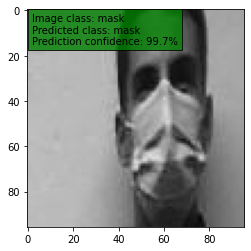

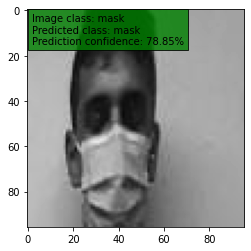

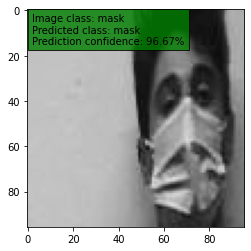

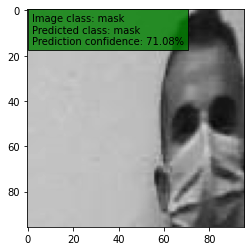

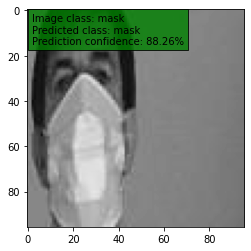

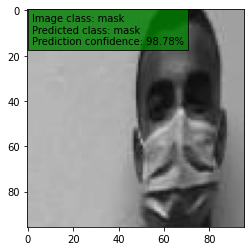

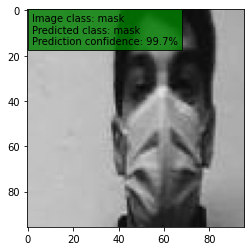

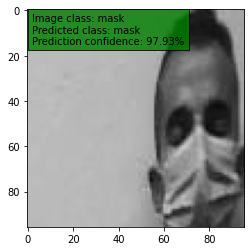

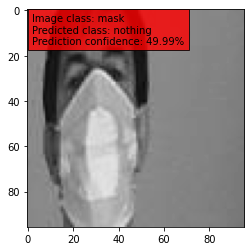

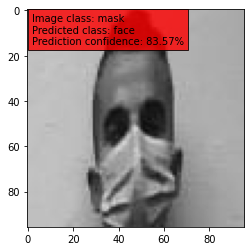

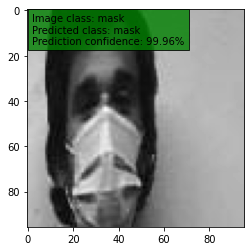

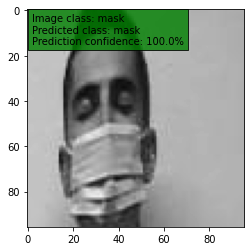

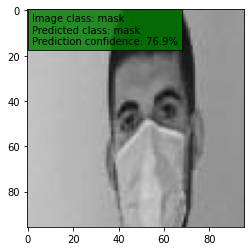

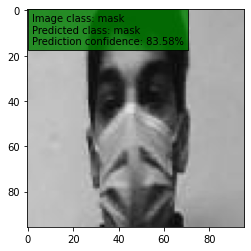

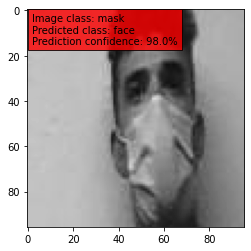

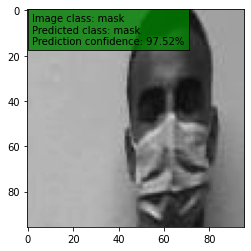

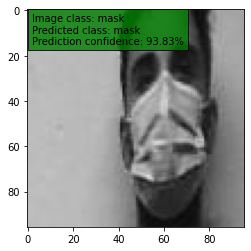

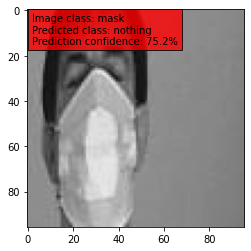

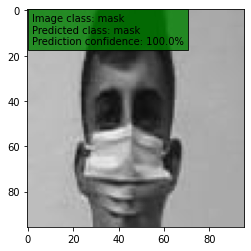

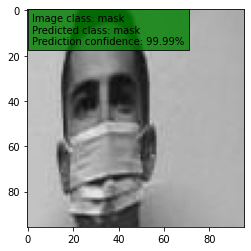

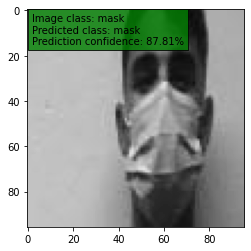

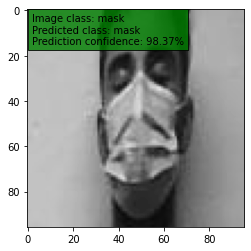

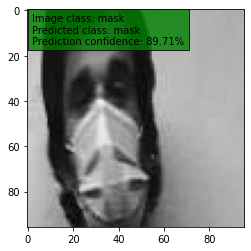

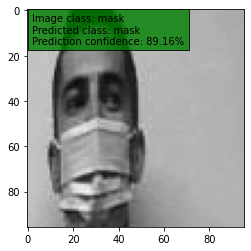

Testing 24 images from class face.


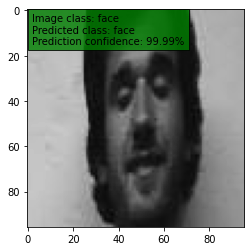

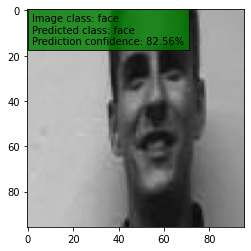

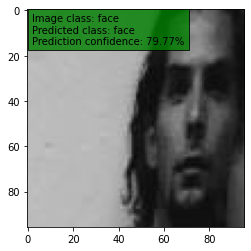

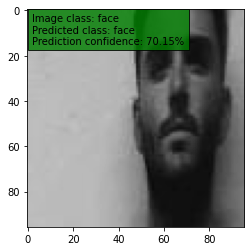

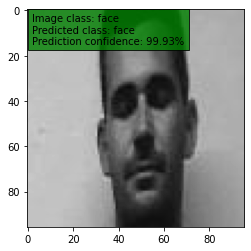

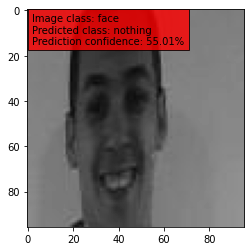

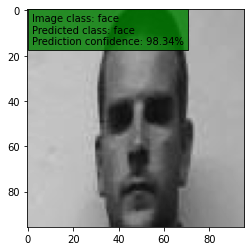

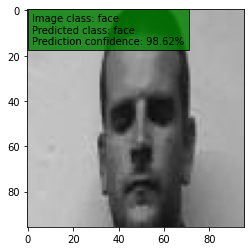

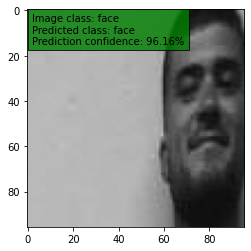

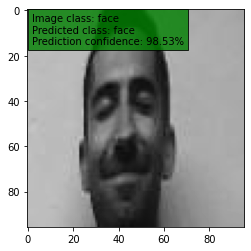

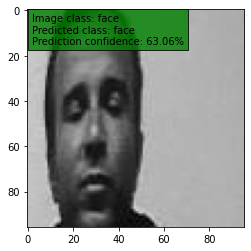

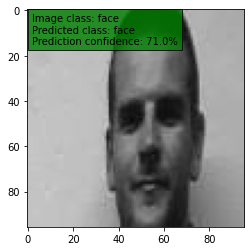

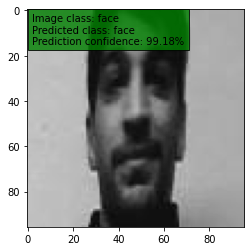

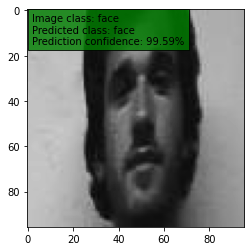

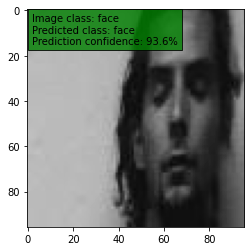

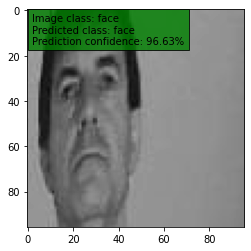

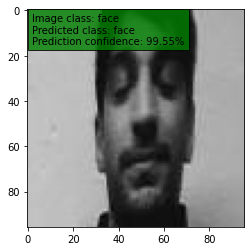

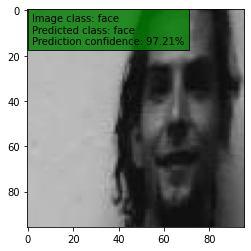

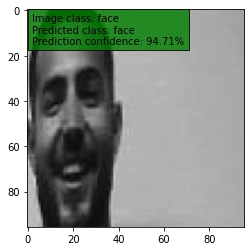

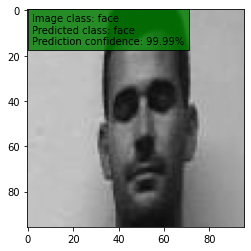

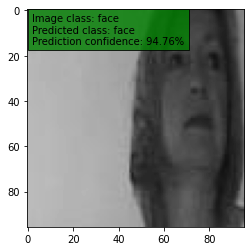

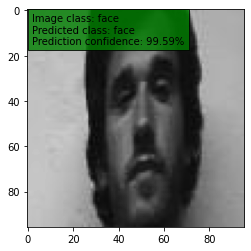

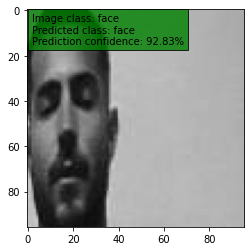

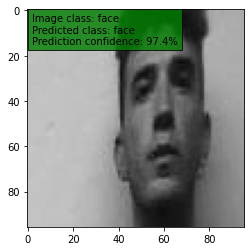

Testing 21 images from class nothing.


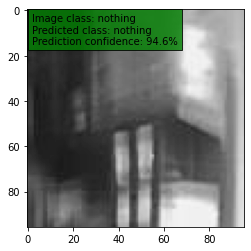

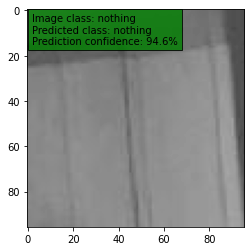

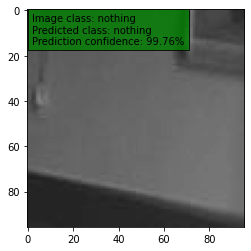

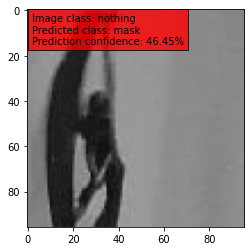

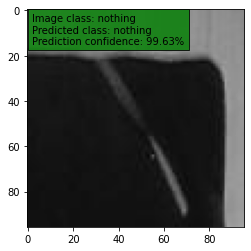

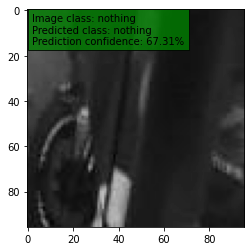

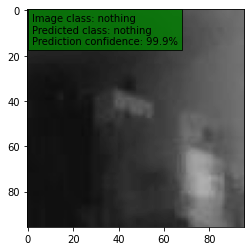

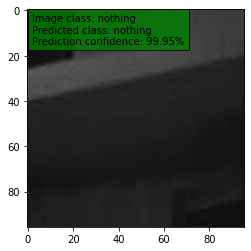

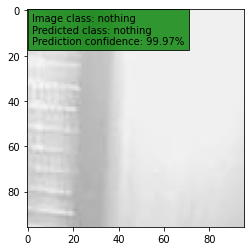

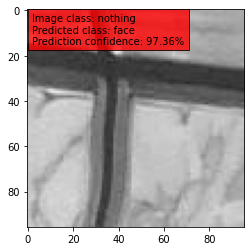

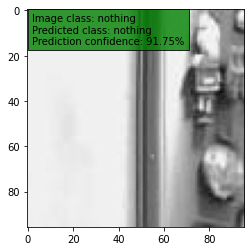

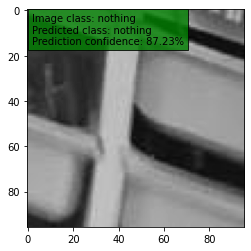

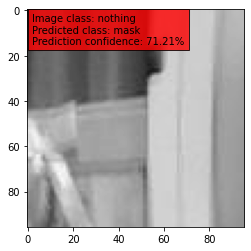

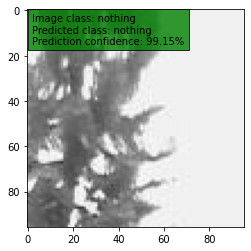

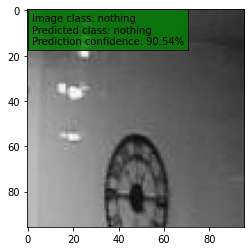

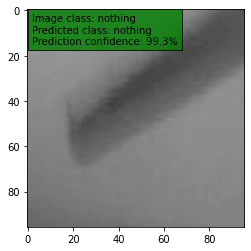

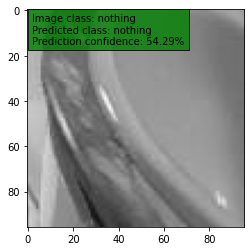

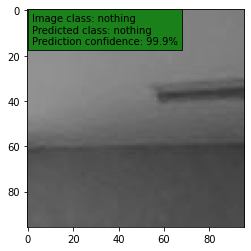

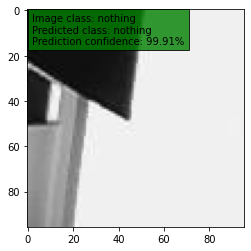

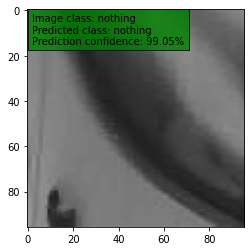

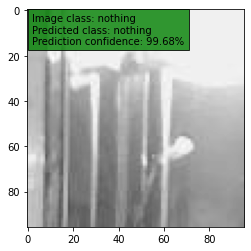

In [4]:
predictions = []
true_labels = []

classes = os.listdir(test_dir)
show_counter = 0

for name in classes:
    class_dir = f"{test_dir}/{name}"
    files = os.listdir(class_dir)
    print(f"Testing {len(files)} images from class {name}.")
    class_index = class_indexes[name]
    for file in files:
        true_labels.append(class_index)

        file_path = f"{test_dir}/{name}/{file}"

        img = load_img(file_path, color_mode=COLOR_MODE)
        img_array = img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)

        prediction = model.predict(img_array)
        score = tf.nn.softmax(prediction[0])

        predicted_class = np.argmax(score)
        predictions.append(predicted_class)
        prediction_score = np.max(score)

        if show_counter % show_interval == 0 or predicted_class != class_index:
            if predicted_class == class_index:
                text_color = "green"
            else:
                text_color = "red"
            plt.figure()
            plt.imshow(img, cmap='gray', vmin=0, vmax=255)
            plt.text(2, 15, f"Image class: {name}\nPredicted class: {class_names[predicted_class]}\nPrediction "
                            f"confidence: {(prediction_score * 100.).round(2)}%", color="black",
                     bbox=dict(facecolor=text_color, alpha=0.8))
            plt.show()

        show_counter +=1

## Visualización de métricas

Se muestran datos acerca del comportamiento general del modelo al evaluar las muestras.

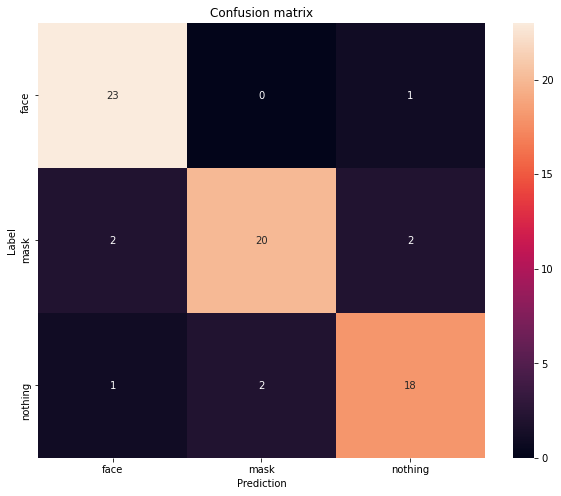

              precision    recall  f1-score   support

        face    0.88462   0.95833   0.92000        24
        mask    0.90909   0.83333   0.86957        24
     nothing    0.85714   0.85714   0.85714        21

    accuracy                        0.88406        69
   macro avg    0.88362   0.88294   0.88224        69
weighted avg    0.88477   0.88406   0.88333        69



In [5]:
confusion_mtx = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=class_names, yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title("Confusion matrix")
plt.show()
print(classification_report(true_labels, predictions, target_names=class_names, digits=DIGITS))